# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

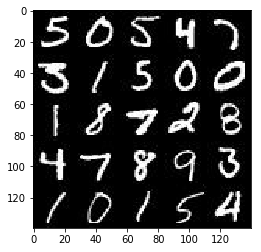

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

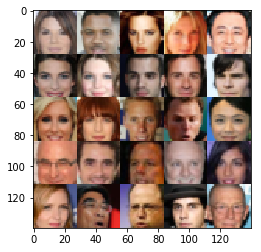

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels), name='input_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32) 
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha = 0.01):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    # Uses architecture resembling that of the DCGAN excercise
    with tf.variable_scope('discriminator', reuse=reuse):
        # input is 28x28x1 or 3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        x1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same')
        # using batch norm on all layers except first and output
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha * x3, x3)
        #4x4x256 = tf.nn.dropout(x3, keep_prob=keep_prob)
        
        #now flatten
        flat = tf.reshape(x3, (-1,  4 * 4 * 256))

        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha = 0.01):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse= not is_train):
        # again, follow basic architecture from DCGAN excercise
        # start with input layer 7x7x512 so we end up with target size of 28x28x3
        h1 = tf.layers.dense(z, 7*7*512)
        # reshape for conv stack
        h1 = tf.reshape(h1, (-1, 7, 7, 512))
        h1 = tf.layers.batch_normalization(h1, training=is_train)
        h1 = tf.maximum(alpha * h1, h1)
        # 7x7x512
        
        # second layer gets halfed in depth, but we use stride of 1 to keep original width/height
        # this way we can use 3 conv layers (7,14,28) instead of two (14,28)
        h2 = tf.layers.conv2d_transpose(h1, 256, kernel_size=5, strides=1, padding='same')
        h2 = tf.layers.batch_normalization(h2, training=is_train)
        h2 = tf.maximum(alpha * h2, h2)
        # 7x7x256
        
        # now change padding to valid to get to 14x14 instead of 12x12
        h3 = tf.layers.conv2d_transpose(h2, 128, kernel_size=5, strides=2, padding='same')
        h3 = tf.layers.batch_normalization(h3, training=is_train)
        h3 = tf.maximum(alpha * h3, h3)
        # 14x14x128
        
        # Output layer, now change kernel size to 5 to achieve target size of 28x28
        logits = tf.layers.conv2d_transpose(h3, out_channel_dim, kernel_size=5,strides=2, padding='same')
        # 28x28x3
        out = tf.tanh(logits)
        
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim, alpha = 0.01):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    # this is mostly the same as in the  DCGAN exercise 
    g_model = generator(input_z, out_channel_dim, is_train=True, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_fake + d_loss_real
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # as in the DCGAN exercise train ops are wrapped so that layers with batch normalization can update
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
        # Get the trainable_variables, split into G and D parts
        t_vars = tf.trainable_variables()
        g_vars = [var for var in t_vars if var.name.startswith('generator')]
        d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        
        return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    show_every = 50
    sample_every = 100
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            steps = 0
            for batch_images in get_batches(batch_size):
                steps +=1
                batch_images = batch_images * 2
                # create random noise as input for generator
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Optimizing
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                
                if steps % show_every == 0:
                    train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...Batch Number {}...".format(epoch_i+1, epochs, steps),
                          "Generator Loss: {:.4f}".format(train_loss_g),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d))

                if steps % sample_every == 0:
                    show_generator_output(sess, show_n_images, input_z, data_shape[3], data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2...Batch Number 50... Generator Loss: 1.7086 Discriminator Loss: 2.1028...
Epoch 1/2...Batch Number 100... Generator Loss: 0.4157 Discriminator Loss: 1.7192...


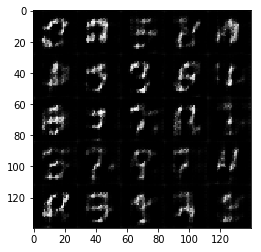

Epoch 1/2...Batch Number 150... Generator Loss: 0.2884 Discriminator Loss: 1.6728...
Epoch 1/2...Batch Number 200... Generator Loss: 1.5920 Discriminator Loss: 1.3992...


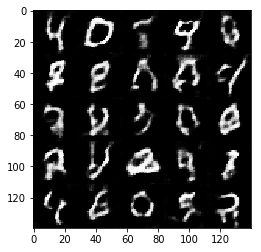

Epoch 1/2...Batch Number 250... Generator Loss: 0.5910 Discriminator Loss: 1.2113...
Epoch 1/2...Batch Number 300... Generator Loss: 0.4434 Discriminator Loss: 1.3406...


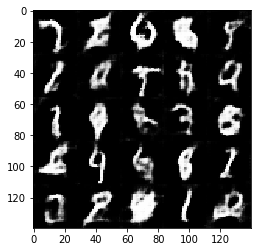

Epoch 1/2...Batch Number 350... Generator Loss: 1.7178 Discriminator Loss: 1.2539...
Epoch 1/2...Batch Number 400... Generator Loss: 0.5491 Discriminator Loss: 1.2996...


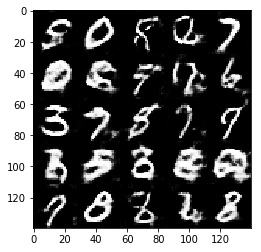

Epoch 1/2...Batch Number 450... Generator Loss: 1.0243 Discriminator Loss: 1.1461...
Epoch 1/2...Batch Number 500... Generator Loss: 0.6307 Discriminator Loss: 1.2438...


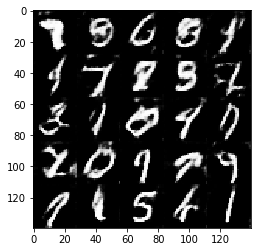

Epoch 1/2...Batch Number 550... Generator Loss: 1.4878 Discriminator Loss: 1.1883...
Epoch 1/2...Batch Number 600... Generator Loss: 0.2523 Discriminator Loss: 1.7987...


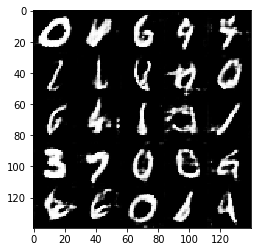

Epoch 1/2...Batch Number 650... Generator Loss: 0.7785 Discriminator Loss: 1.2106...
Epoch 1/2...Batch Number 700... Generator Loss: 0.9180 Discriminator Loss: 1.0644...


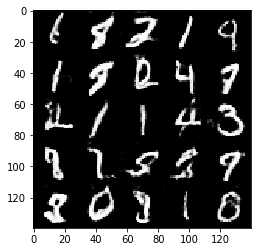

Epoch 1/2...Batch Number 750... Generator Loss: 0.8715 Discriminator Loss: 1.1469...
Epoch 1/2...Batch Number 800... Generator Loss: 0.6878 Discriminator Loss: 1.2261...


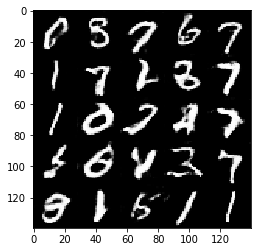

Epoch 1/2...Batch Number 850... Generator Loss: 0.6298 Discriminator Loss: 1.1125...
Epoch 1/2...Batch Number 900... Generator Loss: 1.0381 Discriminator Loss: 1.0227...


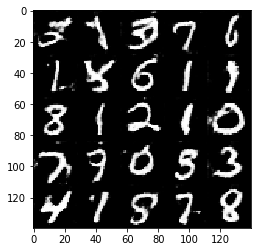

Epoch 2/2...Batch Number 50... Generator Loss: 0.6919 Discriminator Loss: 1.0959...
Epoch 2/2...Batch Number 100... Generator Loss: 0.3146 Discriminator Loss: 1.5623...


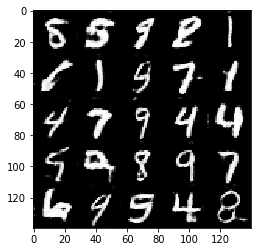

Epoch 2/2...Batch Number 150... Generator Loss: 1.5672 Discriminator Loss: 1.1895...
Epoch 2/2...Batch Number 200... Generator Loss: 0.2491 Discriminator Loss: 1.8177...


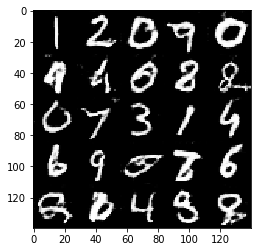

Epoch 2/2...Batch Number 250... Generator Loss: 1.0699 Discriminator Loss: 0.9134...
Epoch 2/2...Batch Number 300... Generator Loss: 0.3738 Discriminator Loss: 1.4634...


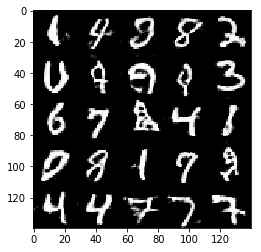

Epoch 2/2...Batch Number 350... Generator Loss: 1.6317 Discriminator Loss: 1.0134...
Epoch 2/2...Batch Number 400... Generator Loss: 0.4142 Discriminator Loss: 1.4219...


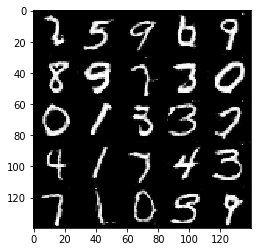

Epoch 2/2...Batch Number 450... Generator Loss: 0.2826 Discriminator Loss: 1.7027...
Epoch 2/2...Batch Number 500... Generator Loss: 0.6735 Discriminator Loss: 1.1091...


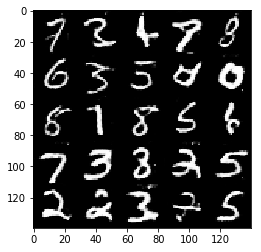

Epoch 2/2...Batch Number 550... Generator Loss: 2.8528 Discriminator Loss: 1.6804...
Epoch 2/2...Batch Number 600... Generator Loss: 0.6614 Discriminator Loss: 1.2844...


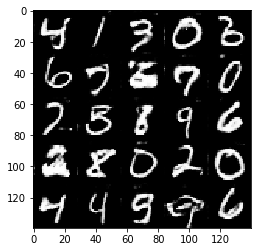

Epoch 2/2...Batch Number 650... Generator Loss: 0.4735 Discriminator Loss: 1.3246...
Epoch 2/2...Batch Number 700... Generator Loss: 2.6170 Discriminator Loss: 1.2178...


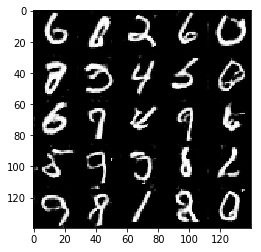

Epoch 2/2...Batch Number 750... Generator Loss: 1.2644 Discriminator Loss: 0.8757...
Epoch 2/2...Batch Number 800... Generator Loss: 0.2530 Discriminator Loss: 1.7340...


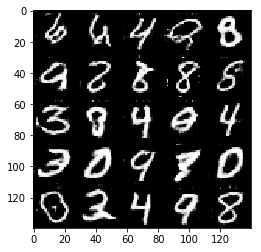

Epoch 2/2...Batch Number 850... Generator Loss: 0.4704 Discriminator Loss: 1.3113...
Epoch 2/2...Batch Number 900... Generator Loss: 1.4314 Discriminator Loss: 0.8084...


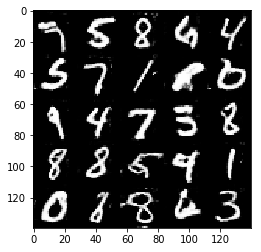

In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.002
beta1 = 0.5



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1...Batch Number 50... Generator Loss: 0.3832 Discriminator Loss: 1.3495...
Epoch 1/1...Batch Number 100... Generator Loss: 1.3397 Discriminator Loss: 0.7582...


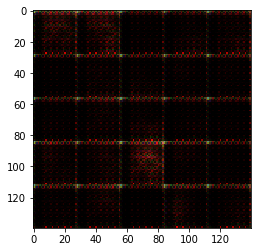

Epoch 1/1...Batch Number 150... Generator Loss: 0.7788 Discriminator Loss: 1.1341...
Epoch 1/1...Batch Number 200... Generator Loss: 1.3736 Discriminator Loss: 0.7716...


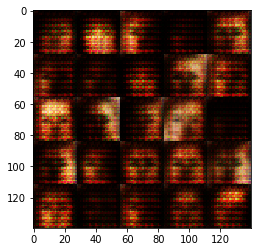

Epoch 1/1...Batch Number 250... Generator Loss: 0.7310 Discriminator Loss: 0.9998...
Epoch 1/1...Batch Number 300... Generator Loss: 0.2509 Discriminator Loss: 1.8468...


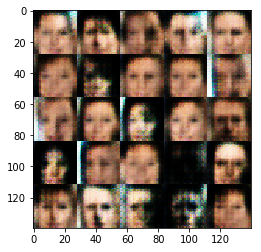

Epoch 1/1...Batch Number 350... Generator Loss: 0.9367 Discriminator Loss: 0.8950...
Epoch 1/1...Batch Number 400... Generator Loss: 1.6887 Discriminator Loss: 1.2781...


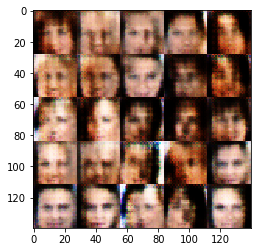

Epoch 1/1...Batch Number 450... Generator Loss: 1.1352 Discriminator Loss: 0.6552...
Epoch 1/1...Batch Number 500... Generator Loss: 1.2191 Discriminator Loss: 0.8511...


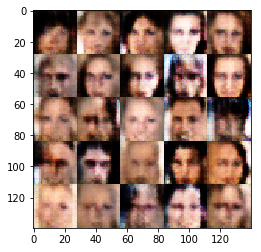

Epoch 1/1...Batch Number 550... Generator Loss: 1.6162 Discriminator Loss: 0.8667...
Epoch 1/1...Batch Number 600... Generator Loss: 1.0439 Discriminator Loss: 0.9065...


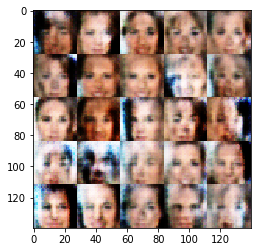

Epoch 1/1...Batch Number 650... Generator Loss: 0.7996 Discriminator Loss: 1.3264...
Epoch 1/1...Batch Number 700... Generator Loss: 0.8499 Discriminator Loss: 1.0378...


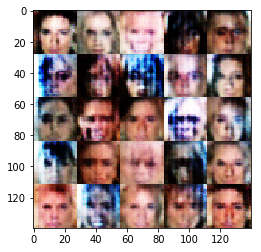

Epoch 1/1...Batch Number 750... Generator Loss: 0.9284 Discriminator Loss: 0.8849...
Epoch 1/1...Batch Number 800... Generator Loss: 0.4759 Discriminator Loss: 1.4184...


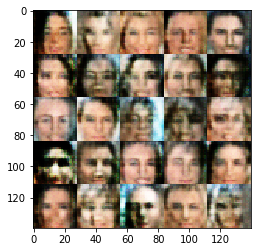

Epoch 1/1...Batch Number 850... Generator Loss: 0.7002 Discriminator Loss: 1.2154...
Epoch 1/1...Batch Number 900... Generator Loss: 0.3235 Discriminator Loss: 1.5502...


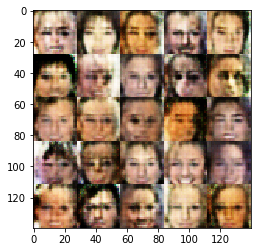

Epoch 1/1...Batch Number 950... Generator Loss: 1.1911 Discriminator Loss: 0.9683...
Epoch 1/1...Batch Number 1000... Generator Loss: 1.1890 Discriminator Loss: 0.9833...


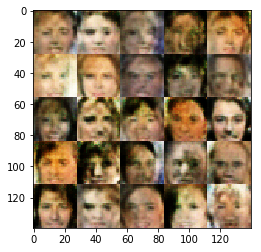

Epoch 1/1...Batch Number 1050... Generator Loss: 1.8293 Discriminator Loss: 0.5276...
Epoch 1/1...Batch Number 1100... Generator Loss: 1.0220 Discriminator Loss: 0.8061...


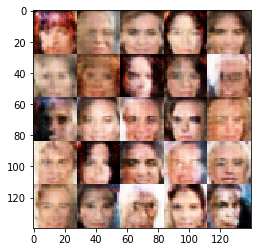

Epoch 1/1...Batch Number 1150... Generator Loss: 1.0842 Discriminator Loss: 1.2144...
Epoch 1/1...Batch Number 1200... Generator Loss: 0.8081 Discriminator Loss: 0.8547...


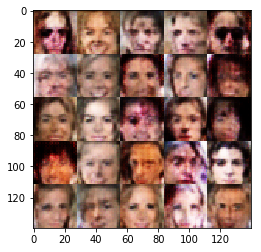

Epoch 1/1...Batch Number 1250... Generator Loss: 0.6884 Discriminator Loss: 1.1214...
Epoch 1/1...Batch Number 1300... Generator Loss: 1.3742 Discriminator Loss: 0.5687...


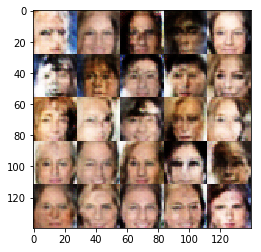

Epoch 1/1...Batch Number 1350... Generator Loss: 0.6375 Discriminator Loss: 1.1797...
Epoch 1/1...Batch Number 1400... Generator Loss: 1.2872 Discriminator Loss: 1.2377...


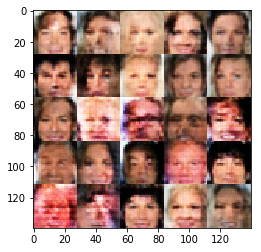

Epoch 1/1...Batch Number 1450... Generator Loss: 1.5646 Discriminator Loss: 1.2223...
Epoch 1/1...Batch Number 1500... Generator Loss: 0.9525 Discriminator Loss: 0.9636...


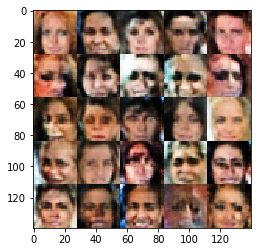

Epoch 1/1...Batch Number 1550... Generator Loss: 0.7679 Discriminator Loss: 1.4461...
Epoch 1/1...Batch Number 1600... Generator Loss: 1.0495 Discriminator Loss: 1.2871...


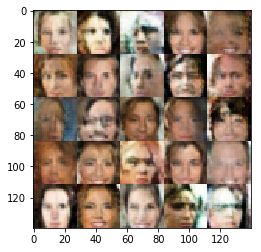

Epoch 1/1...Batch Number 1650... Generator Loss: 1.2198 Discriminator Loss: 0.9562...
Epoch 1/1...Batch Number 1700... Generator Loss: 3.1060 Discriminator Loss: 1.9024...


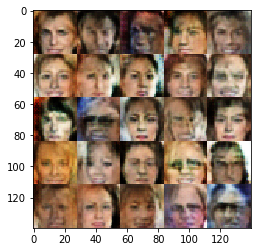

Epoch 1/1...Batch Number 1750... Generator Loss: 0.7754 Discriminator Loss: 1.2656...
Epoch 1/1...Batch Number 1800... Generator Loss: 0.8151 Discriminator Loss: 1.1148...


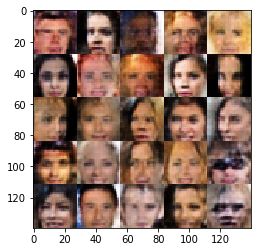

Epoch 1/1...Batch Number 1850... Generator Loss: 0.6754 Discriminator Loss: 1.5175...
Epoch 1/1...Batch Number 1900... Generator Loss: 0.5848 Discriminator Loss: 1.2091...


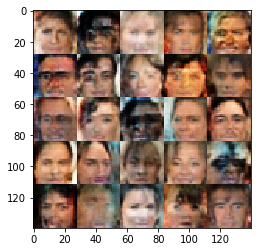

Epoch 1/1...Batch Number 1950... Generator Loss: 0.9691 Discriminator Loss: 1.1447...
Epoch 1/1...Batch Number 2000... Generator Loss: 0.8080 Discriminator Loss: 1.2004...


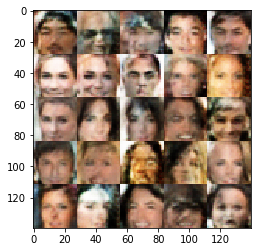

Epoch 1/1...Batch Number 2050... Generator Loss: 0.6624 Discriminator Loss: 1.0560...
Epoch 1/1...Batch Number 2100... Generator Loss: 0.7253 Discriminator Loss: 1.0999...


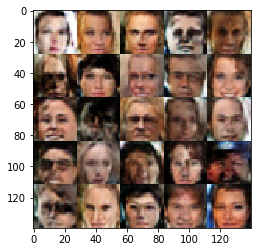

Epoch 1/1...Batch Number 2150... Generator Loss: 0.4321 Discriminator Loss: 1.4875...
Epoch 1/1...Batch Number 2200... Generator Loss: 0.8637 Discriminator Loss: 1.3071...


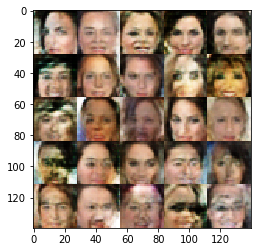

Epoch 1/1...Batch Number 2250... Generator Loss: 0.6866 Discriminator Loss: 1.1362...
Epoch 1/1...Batch Number 2300... Generator Loss: 1.1386 Discriminator Loss: 0.7989...


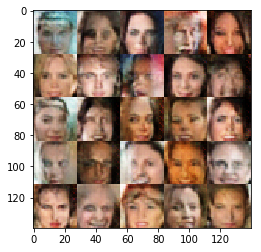

Epoch 1/1...Batch Number 2350... Generator Loss: 0.4234 Discriminator Loss: 1.4341...
Epoch 1/1...Batch Number 2400... Generator Loss: 0.5813 Discriminator Loss: 1.1338...


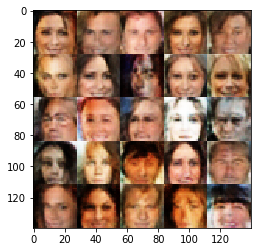

Epoch 1/1...Batch Number 2450... Generator Loss: 0.4737 Discriminator Loss: 1.3496...
Epoch 1/1...Batch Number 2500... Generator Loss: 0.2049 Discriminator Loss: 2.0299...


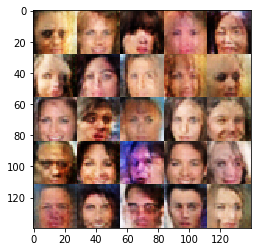

Epoch 1/1...Batch Number 2550... Generator Loss: 0.7257 Discriminator Loss: 1.0919...
Epoch 1/1...Batch Number 2600... Generator Loss: 1.0053 Discriminator Loss: 1.1698...


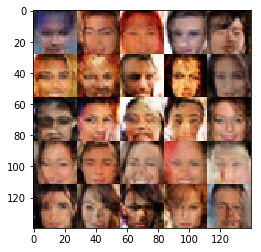

Epoch 1/1...Batch Number 2650... Generator Loss: 0.8590 Discriminator Loss: 1.1224...
Epoch 1/1...Batch Number 2700... Generator Loss: 0.7238 Discriminator Loss: 1.1786...


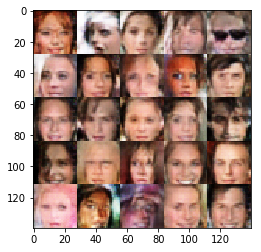

Epoch 1/1...Batch Number 2750... Generator Loss: 1.0540 Discriminator Loss: 1.3868...
Epoch 1/1...Batch Number 2800... Generator Loss: 0.9264 Discriminator Loss: 1.0364...


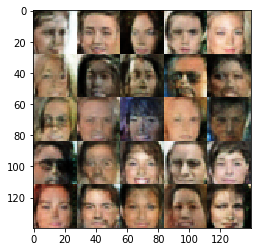

Epoch 1/1...Batch Number 2850... Generator Loss: 0.5440 Discriminator Loss: 1.4246...
Epoch 1/1...Batch Number 2900... Generator Loss: 1.1657 Discriminator Loss: 0.9263...


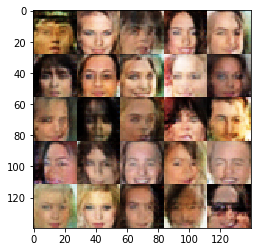

Epoch 1/1...Batch Number 2950... Generator Loss: 0.7350 Discriminator Loss: 1.2848...
Epoch 1/1...Batch Number 3000... Generator Loss: 0.1949 Discriminator Loss: 1.9323...


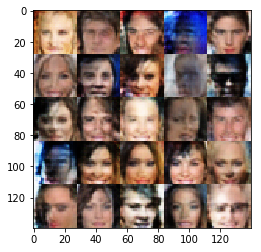

Epoch 1/1...Batch Number 3050... Generator Loss: 0.4891 Discriminator Loss: 1.4270...
Epoch 1/1...Batch Number 3100... Generator Loss: 0.3107 Discriminator Loss: 1.6342...


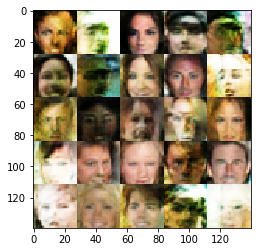

Epoch 1/1...Batch Number 3150... Generator Loss: 0.3851 Discriminator Loss: 1.5915...


In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.